# Drzewa decyzyjne


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Funkcje

In [2]:
import pandas as pd
import matplotlib.ticker as ticker

def load_dataset(filename, class_column, index_col=None):
    dataset = pd.read_csv(f'ML-datasets/{filename}.csv', index_col=index_col)
    dataset['class'] = dataset[class_column].astype('category').cat.codes
    classes = dataset.pop(class_column).unique()
    return dataset, classes

def prepare_dataset(dataset_name):
    params = {'iris': {'class_column': 'species', 'index_col': None},
              'wine': {'class_column': 'Class', 'index_col': None},
              'glass': {'class_column': 'Type', 'index_col': 'ID'}}
    dataset, classes = load_dataset(dataset_name,
                                    **params[dataset_name])
    y = dataset.pop('class')
    X = dataset
    return X, y, classes


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# average:
#   None - wyniki dla każdej klasy osobno
#   'binary' - dla wybranej w `pos_label` etykiety
#   'micro' - dla całkowitej liczby TP, FN, FP
#   'macro' - nieważona średnia dla każdej klasy
#   'weighted' - ważona średnia dla każdej klasy

def calculate_metrics(target, prediction, average='macro'):
    accuracy = accuracy_score(target, prediction)
    precision = precision_score(target, prediction, average=average)
    recall = recall_score(target, prediction, average=average)
    f1 = f1_score(target, prediction, average=average)
    mislabeled = (target != prediction).sum()
    total = len(target)
    return accuracy, precision, recall, f1, mislabeled, total

def print_results(metrics, classifier_id='classifier'):
    print(f'Results for {classifier_id}')
    print('----')
    print(f'  Accuracy:  {metrics[0]}')
    print(f'  Precision: {metrics[1]}')
    print(f'  Recall:    {metrics[2]}')
    print(f'  F1 score:  {metrics[3]}')
    print(f'  Mislabeled {metrics[4]} out of {metrics[5]}')
    print('\n')

def plot_confusion_matrix(cm, classes, title=None, title_appendix = '', cmap = plt.cm.Blues):

    if title_appendix:
        title_appendix = f'({title_appendix})'

    if title is None:
        title = f'Confusion Matrix {title_appendix}'

    fig, ax = plt.subplots(figsize = (10,5))

    img = ax.imshow(cm, cmap = cmap)

    ax.figure.colorbar(img, ax = ax)

    # Określanie lokalizacji ticków
    ticks = np.arange(len(classes))
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)

    # Ustawienie lokalizatora
    ax.xaxis.set_major_locator(ticker.FixedLocator(ticks))
    ax.yaxis.set_major_locator(ticker.FixedLocator(ticks))

    ax.set_title(title)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

    fmt = '.2f' if cm.dtype =='float' else 'd'

    for y, row in enumerate(cm):
        for x, cell in enumerate(row):
            ax.text(x,y, format(cell, fmt), ha ='center', color = 'white' if cell > cm.max()/2 else 'black')

    # Teraz możemy bezpiecznie użyć set_xticklabels() i set_yticklabels()
    ax.set_xticklabels(classes, rotation = 90)
    ax.set_yticklabels(classes, rotation = 0)

    return ax

def normalize_confusion_matrix(confusion_matrix):
    return confusion_matrix.astype('float') /confusion_matrix.sum(axis = 1)[np.newaxis].T

## Budowa modelu na danych rzeczywistych

In [ ]:
!git clone https://github.com/matzim95/ML-datasets

Cloning into 'ML-datasets'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 71 (delta 16), reused 59 (delta 12), pack-reused 0
Unpacking objects: 100% (71/71), done.


In [2]:
import pandas as pd

def load_dataset(filename, class_column, index_col=None):
    dataset = pd.read_csv(f'ML-datasets/{filename}.csv', index_col=index_col)
    dataset['class'] = dataset[class_column].astype('category').cat.codes
    classes = dataset.pop(class_column).unique()
    return dataset, classes

def prepare_dataset(dataset_name):
    params = {'iris': {'class_column': 'species', 'index_col': None},
              'wine': {'class_column': 'Class', 'index_col': None},
              'glass': {'class_column': 'Type', 'index_col': 'ID'}}
    dataset, classes = load_dataset(dataset_name,
                                    **params[dataset_name])
    y = dataset.pop('class')
    X = dataset
    return X, y, classes

Zdefiniujmy sobie szereg funkcji, z których będziemy korzystać

Wczytajmy zbiór i dokonajmy podziału. W przypadku drzew dane nie wymagają normalizacji czy dyskretyzacji.

In [3]:
wine, wine_classes = load_dataset('wine', 'Class')

y = wine.pop('class')
X = wine
X.head()

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

In [6]:
dt = DecisionTreeClassifier(max_depth = 2, criterion = 'entropy')
dt.fit(X_train, y_train)

y_pred_train = dt.predict(X_train)
y_pred = dt.predict(X_test)

Następnie dokonajmy klasyfikacji i oceny modelu w oparciu o zdefiniowane funkcje

Results for classifier
----
  Accuracy:  0.9647887323943662
  Precision: 0.9648719886815126
  Recall:    0.9695159885529426
  F1 score:  0.9667670917670916
  Mislabeled 5 out of 142


Results for classifier
----
  Accuracy:  0.9444444444444444
  Precision: 0.9505494505494506
  Recall:    0.9428571428571427
  F1 score:  0.9453132832080202
  Mislabeled 2 out of 36




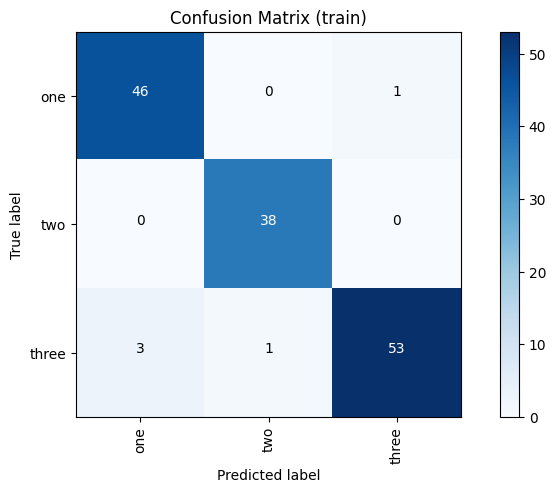

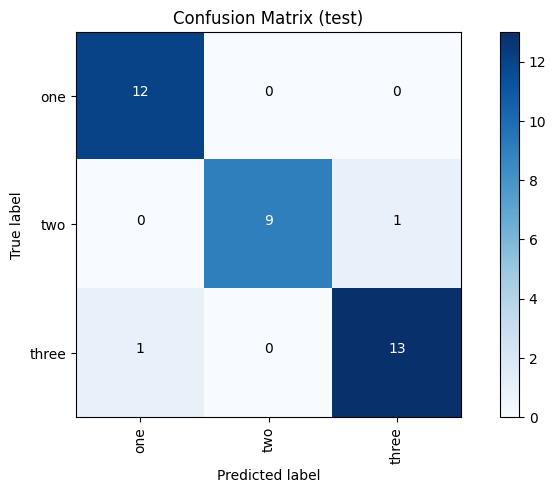

In [7]:
from sklearn.metrics import confusion_matrix
print_results(calculate_metrics(y_train, y_pred_train))
print_results(calculate_metrics(y_test, y_pred))

plot_confusion_matrix(confusion_matrix(y_train, y_pred_train), wine_classes, title_appendix = 'train');
plot_confusion_matrix(confusion_matrix(y_test, y_pred), wine_classes, title_appendix = 'test');

Oraz narysujmy wykres drzewa

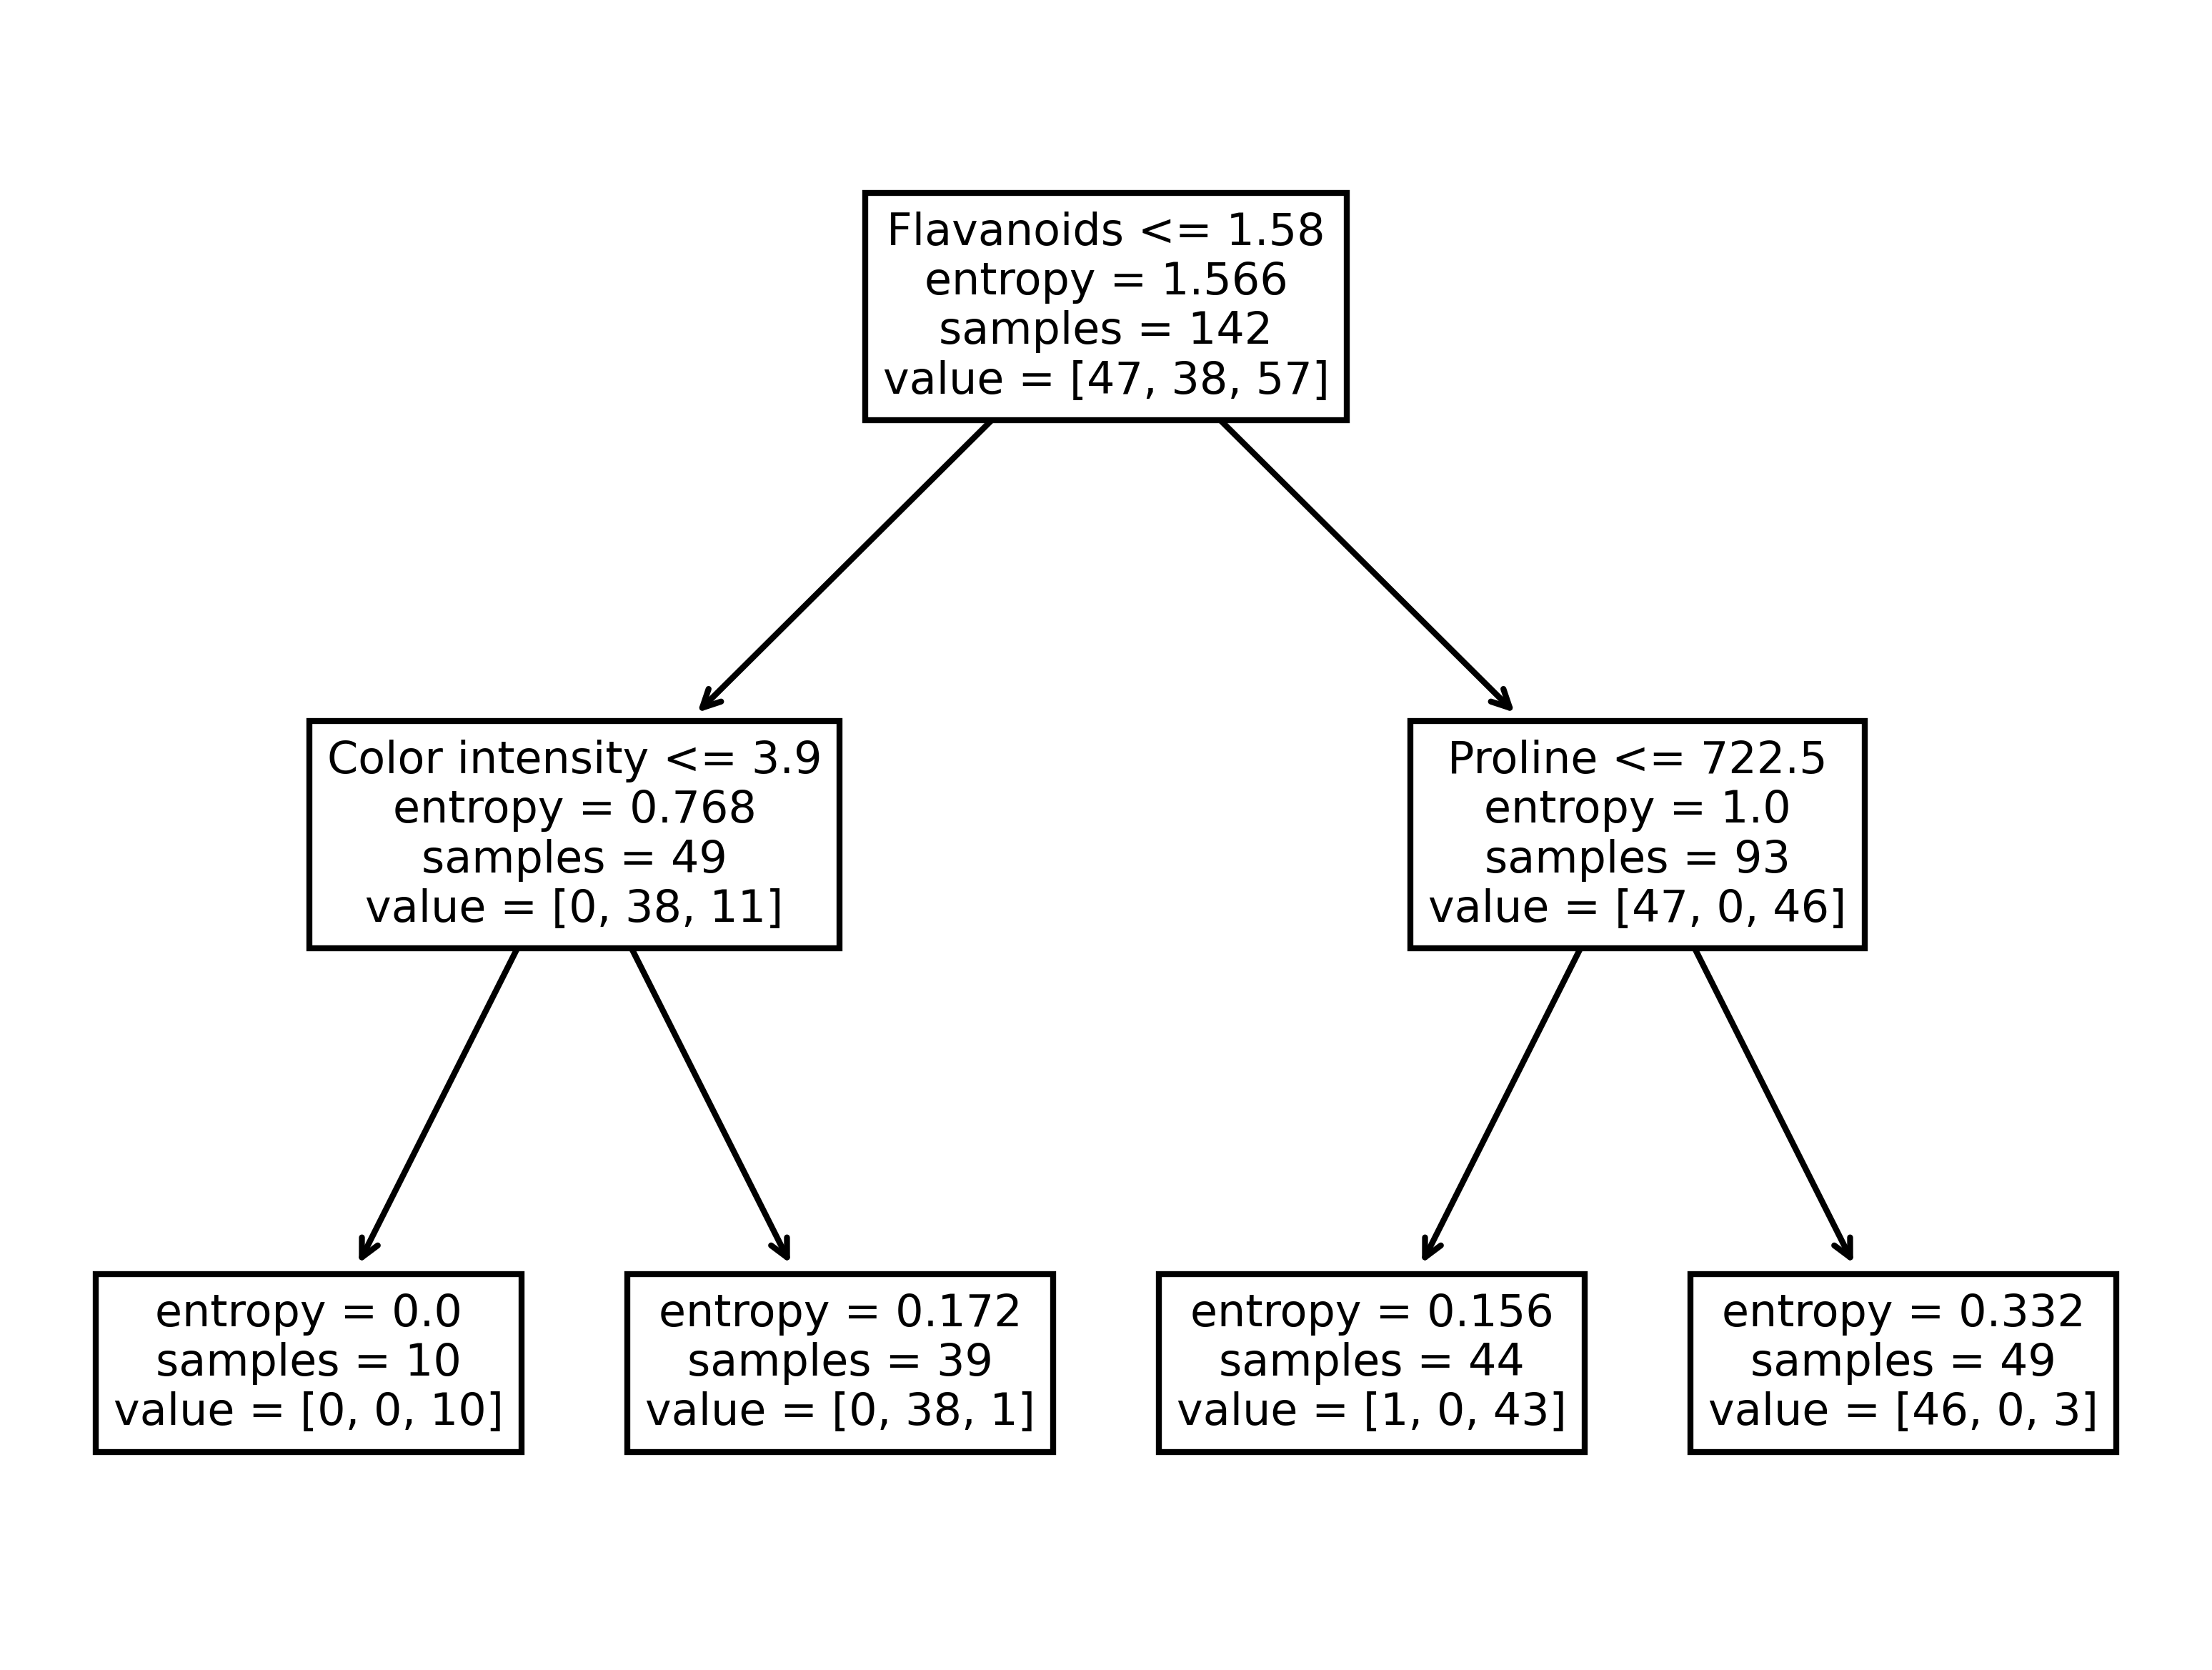

In [8]:
plt.figure(dpi=600)
plot_tree(dt, feature_names = X.columns)
plt.show()

## Granice decyzyjne

DecisionTreeClassifier()

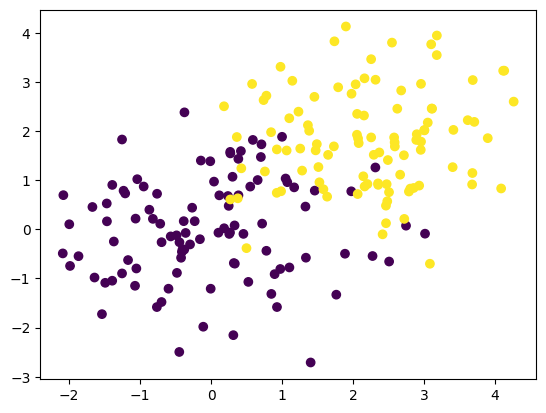

In [9]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# losowe dane dla dwóch klas, przy przesunięciu środka rozkładu
train_data = np.vstack((np.random.normal(size=(100, 2)),
                        np.random.normal(size=(100, 2), loc=2)))

train_labels = np.hstack((np.zeros(100), np.ones(100)))

# np.vstack - połaczenie tablic wertykalne
# np.hstack - połączenie tablic horyzontalne

fig, ax = plt.subplots()
ax.scatter(train_data[:,0], train_data[:,1], c =train_labels)

model = DecisionTreeClassifier()
model.fit(train_data, train_labels)

In [10]:
x_min, x_max = train_data[:,0].min() -1, train_data[:,0].max() +1
y_min, y_max = train_data[:,1].min() -1, train_data[:,1].max() +1

xs, ys = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

y_pred = model.predict(np.column_stack((xs.flatten(),
                                       ys.flatten())))

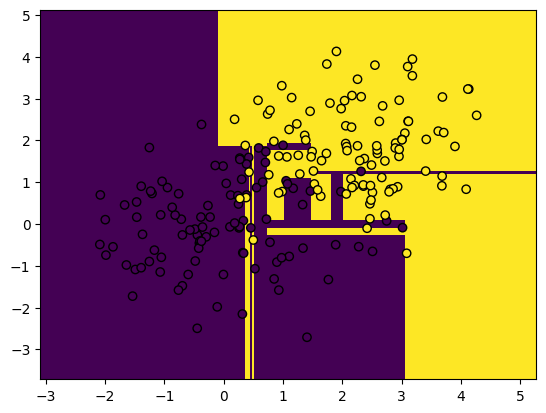

In [11]:
y_pred_matrix = y_pred.reshape(xs.shape)

fig, ax = plt.subplots()
ax.pcolormesh(xs, ys, y_pred_matrix)
ax.scatter(train_data[:,0], train_data[:,1], c=train_labels, edgecolors = 'k')
plt.show()

## Gotowa funkcja do wyliczenia wyniku modelu

croswalidacja z normalizacją

In [12]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, StratifiedKFold

def count_model(classifier, kfold, X,y, classes, params = None, scaling = None, numeric_features = None, results = None, plot = None, print_params = None):
    
    # Dodanie parametrów do klasyfikatora:
    if params is None:
        params = {}
        clf = classifier(**params)
    else:
        clf = classifier(**params)
    
    # Listy, które będą przechowywać wyniki:
    predicted = []
    target = []
    
    
    # Definiowanie skalera:
    
    if scaling == 'minmax':
        scaler = MinMaxScaler()
    elif scaling == 'standard':
        scaler = StandardScaler()
    elif scaling is None:
        pass
    else:
        print('Wybierz scaler z listy: minmax, standard')

    # Model z walidacją krzyżową:    
    for train_index, test_index in kfold.split(X,y):
        X_train, X_test = X.iloc[train_index].copy(), X.iloc[test_index].copy()
        y_train, y_test = y.iloc[train_index].copy(), y.iloc[test_index].copy()

    if scaling and numeric_features:
        
        # Skalowanie zbiorów treninowego i testowego, jeśli podaliśmy skaler, dla każdej iteracji, walidacji krzyżowej:
        X_train_scaled = X_train.copy()
        X_test_scaled = X_test.copy()
        
        X_train_scaled[numeric_features] = scaler.fit_transform(X_train[numeric_features])
        X_test_scaled[numeric_features] = scaler.transform(X_test[numeric_features])
        
        X_train = X_train_scaled
        X_test = X_test_scaled
    
    # Model:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    target = np.concatenate((target, y_test))
    predicted = np.concatenate((predicted, y_pred))
    
    
    # Print parametrów, resultatów i wykresów:
    if print_params:
        print('PARAMS:\n\n', clf.get_params(),'\n')

    if results:
        print('RESULTS:\n')
        print_results(calculate_metrics(target, predicted))

    if plot:
        print('PLOT:\n')
        plot_confusion_matrix(confusion_matrix(target, predicted), classes)
        plot_confusion_matrix(normalize_confusion_matrix(confusion_matrix(target, predicted)), classes)

PARAMS:

 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 2, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'} 

RESULTS:

Results for classifier
----
  Accuracy:  0.9830508474576272
  Precision: 0.9866666666666667
  Recall:    0.9824561403508771
  F1 score:  0.9841882699025556
  Mislabeled 1 out of 59


PLOT:



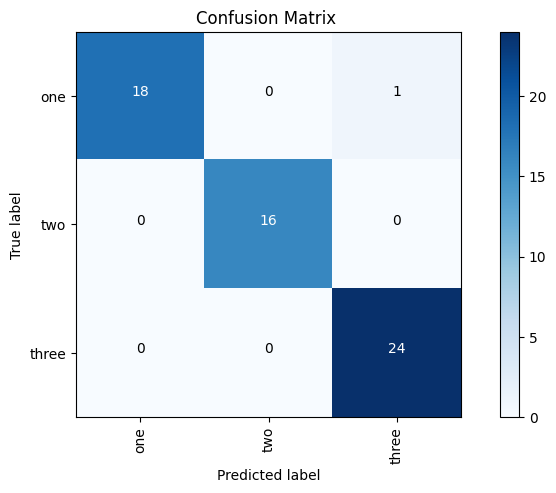

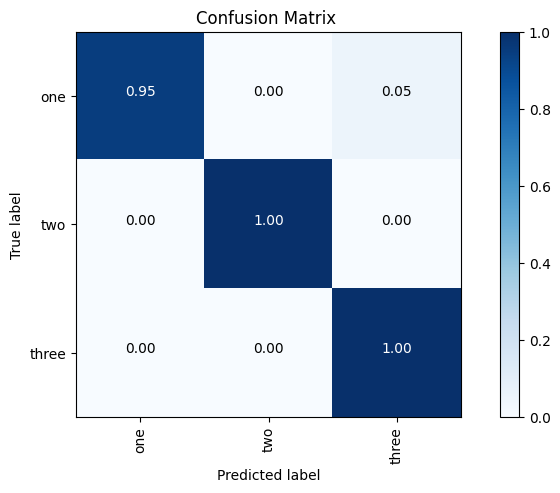

In [13]:
from sklearn.model_selection import KFold, StratifiedKFold
count_model(DecisionTreeClassifier,
            StratifiedKFold(3),
            X,
            y,
            wine_classes,
            params = {'max_depth':2, 'criterion':'entropy'},
            #scaling = 'minmax',
            #numeric_features = ['Alcohol', 'Malic acid', 'Ash'],
            results = True,
            plot = True,
            print_params = True)

Funkcja trenująca model z walidacją krzyżową i wyliczjąca parametry.

In [14]:
X.columns

Index(['Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium',
       'Total phenols', 'Flavanoids', 'Nonflavanoid phenols',
       'Proanthocyanins', 'Color intensity', 'Hue',
       'OD280/OD315 of diluted wines', 'Proline'],
      dtype='object')

In [15]:
X.head()

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
